In [1]:

# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
ld_trans = pd.read_excel('penske consumer lite duty round trip 2022 to 2023 ytd transactions.xlsx',sheet_name='data')
util = pd.read_excel('LaMirada_Summed_Utilization.xlsx', sheet_name='Sheet1')

#subset to atlanta_west district
ld_trans = ld_trans[ld_trans['DISTRICT'] == '7337 - LA MIRADA               ']


ld_trans.reset_index(inplace=True,drop=True)

In [3]:
#subset to all utilization
util = util[['Date', 'SumOfFLEET Gas', 'SumOfFLEET Parcel', 'SumOfFLEET All', 'Utilization Rate All']]

In [4]:
print(ld_trans.columns)

Index(['REGION', 'AREA', 'DISTRICT', 'LOCATION', 'CUSTOMER_KEY',
       'SOURCE_OPTION_NAME', 'QUOTE CREATED', 'RES CREATED',
       'CONTRACT CREATED', 'TRANS #', 'DATE OUT', 'TIME OUT', 'DATE IN',
       'TIME IN', 'CONTRACT CLOSED', 'UNIT NUMBER', 'Category', 'GROUP',
       'RATE DAY', 'RATE WEEK', 'RATE MILE', 'MILES OUT', 'MILES IN',
       'MILES USED', 'FUEL_OUT_LEVEL', 'FUEL_IN_LEVEL', 'DAMAGE_OUT',
       'DAMAGE_IN', 'VEH_TOTAL'],
      dtype='object')


In [5]:
ld_trans['DURATION'] = (ld_trans['DATE IN'] - ld_trans['DATE OUT']).dt.total_seconds()/(24*60*60)
ld_trans['MILEAGE PRICE'] = ld_trans['RATE MILE'] * ld_trans['MILES USED']
ld_trans['FUEL LOST'] = ld_trans['FUEL_OUT_LEVEL'] - ld_trans['FUEL_IN_LEVEL']
ld_trans['DAMAGED'] = ((ld_trans['DAMAGE_IN'] == 'Y') & (ld_trans['DAMAGE_OUT'] == 'N')).astype(int)

bins = np.arange(0, 11, 1)  # This creates an array [0, 1, 2, ..., 10]

ld_trans.loc[ld_trans['DURATION'] == 0, 'DURATION'] = 1

ld_trans['BOARD PRICE'] = ld_trans['RATE DAY']*ld_trans['DURATION']
ld_trans['EXP PRICE'] = ld_trans['BOARD PRICE'] + ld_trans['MILEAGE PRICE']

In [6]:
cols = ['RES CREATED','DATE OUT','TIME OUT','TIME IN','DATE IN','RATE DAY','RATE WEEK','RATE MILE','MILES USED','FUEL LOST','DAMAGED','VEH_TOTAL','DURATION','MILEAGE PRICE','BOARD PRICE','EXP PRICE','GROUP']


ld_trans = ld_trans[cols]

In [7]:
start_date = ld_trans['DATE OUT'].min()
end_date = ld_trans['DATE IN'].max()

ld_trans['Date'] = ld_trans['DATE OUT']

date_range = pd.date_range(start=start_date, end=end_date)

# Create a dataframe with this date range
df_base = pd.DataFrame(date_range, columns=['Date'])

# Left join other dataframes with this base dataframe
df_utilization_aligned = df_base.merge(util, on='Date', how='left')

# 3. Merge the Data
df_combined = ld_trans.merge(df_utilization_aligned, on='Date', how='left')

In [8]:
def create_uhaul_price(current_date, reservation_date, duration, mileage):
    
    #get days reserved in advanced
    adv = (reservation_date - current_date).total_seconds() / (60*60*24)
    
    board_rate = 19.95 * duration
    mileage_rate = .59 if adv >= 2 else .69
    
    return board_rate + mileage_rate * mileage

In [9]:
data = df_combined.dropna().drop('Date',axis=1)

mapping = {'LITE DUTY DIESEL': 1,
           'LITE DUTY GAS': 2,
           'PARCEL VAN-LITE DUTY': 3}

data['GROUP'] = data['GROUP'].replace(mapping)

data.reset_index(inplace=True,drop=True)
data['UHAUL PRICE'] = [create_uhaul_price(data.loc[i,'RES CREATED'], data.loc[i,'DATE OUT'], data.loc[i,'DURATION'], data.loc[i,'MILES USED']) for i in range(len(data))]

In [10]:
data.to_csv('Data_Atlanta_West.csv',index=False)

In [11]:
cols = ['RATE DAY','RATE MILE', 'VEH_TOTAL', 'SumOfFLEET Gas', 'SumOfFLEET Parcel', 'SumOfFLEET All', 'UHAUL PRICE','Utilization Rate All']

df = data[cols]

data['DATE OUT'] = pd.to_datetime(data['DATE OUT'])

print(df.dtypes)

RATE DAY                float64
RATE MILE               float64
VEH_TOTAL               float64
SumOfFLEET Gas          float64
SumOfFLEET Parcel       float64
SumOfFLEET All          float64
UHAUL PRICE             float64
Utilization Rate All    float64
dtype: object


In [12]:
#%% train and test sets

split = int(.7*len(df))

X_train = df.loc[:split,:].drop(['Utilization Rate All'],axis=1)
y_train = df.loc[:split,'Utilization Rate All']

X_test = df.loc[split:,:].drop(['Utilization Rate All'],axis=1)
y_test = df.loc[split:,'Utilization Rate All']


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Calculate the mean squared error for the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}")

r_squared = r2_score(y_test, y_pred_lr)
print("R-squared:", r_squared)

# Sorting the coefficients in descending order
sorted_coeffs = sorted(zip(X_train.columns, lr.coef_), key=lambda x: x[1], reverse=True)

# Print the intercept
print("Intercept:", lr.intercept_)

# Print the sorted coefficients for each feature
for feature, coef in sorted_coeffs:
    print(f"{feature}: {coef}")


print('________________________________________________')

Linear Regression MSE: 0.003356020364709703
R-squared: 0.2558894588640923
Intercept: 1.1991553230982641
SumOfFLEET All: 0.004599867630346141
RATE MILE: 0.0006027468718939385
VEH_TOTAL: -6.355920765454539e-06
UHAUL PRICE: -1.2086557358919941e-05
RATE DAY: -7.935757201548411e-05
SumOfFLEET Parcel: -0.007155191313354247
SumOfFLEET Gas: -0.008599806482197983
________________________________________________


In [14]:
features = df.drop('Utilization Rate All', axis=1)
labels = df['Utilization Rate All']

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

feature_list = list(features.columns)


Training Features Shape: (3946, 7)
Training Labels Shape: (3946,)
Testing Features Shape: (1316, 7)
Testing Labels Shape: (1316,)


In [15]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
mse_rf = mean_squared_error(test_labels, predictions)
print(f"RandomForest MSE: {mse_rf}")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.01 degrees.
RandomForest MSE: 0.0006678303646485336
Accuracy: 97.54 %.


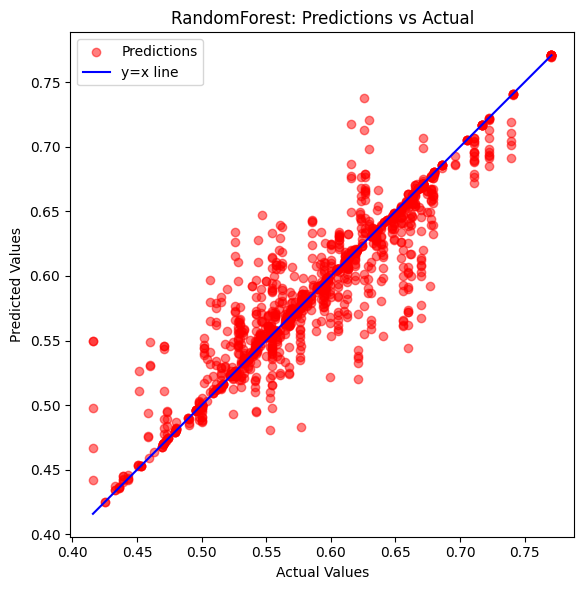

In [16]:
import matplotlib.pyplot as plt

#Random Forest Predictions vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_labels, predictions, color='red', alpha=0.5, label='Predictions')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='blue', label='y=x line')
plt.title('RandomForest: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('square')

plt.tight_layout()
plt.show()

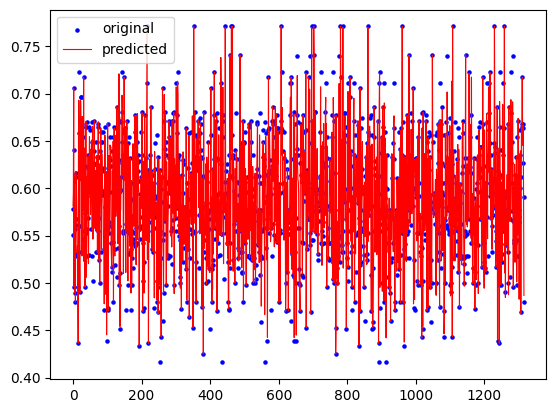

In [17]:
rf_x_ax = range(len(test_labels))
plt.scatter(rf_x_ax, test_labels, s=5, color="blue", label="original")
plt.plot(rf_x_ax, predictions, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

MSE: 0.00


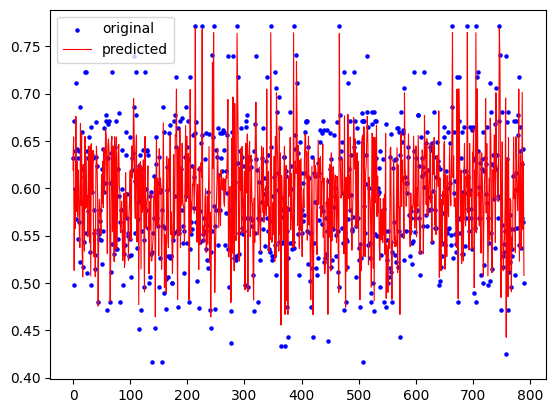

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
x = df.drop('Utilization Rate All', axis=1)
y = df['Utilization Rate All']

xtrain, xtest, ytrain, ytest=train_test_split(x, y, random_state=12, 
             test_size=0.15)
# with new parameters
gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)
# with default parameters
#gbr = GradientBoostingRegressor()

gbr.fit(xtrain, ytrain)

ypred = gbr.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("MSE: %.2f" % mse)

x_ax = range(len(ytest))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

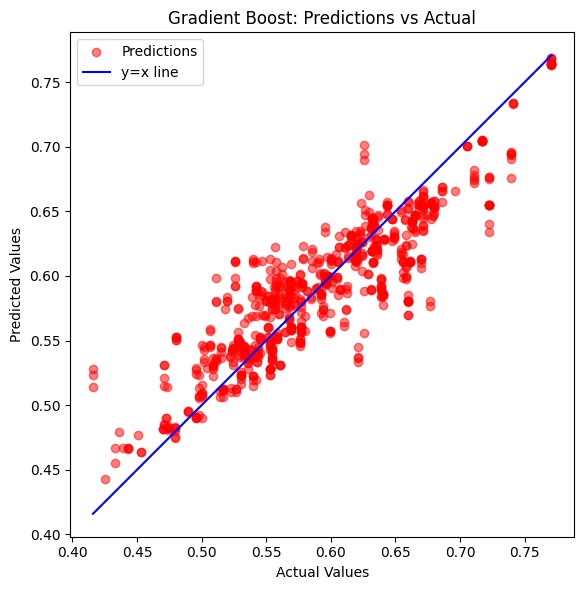

Mean Absolute Error: 0.02 degrees.
Accuracy: 96.01 %.


In [19]:
import matplotlib.pyplot as plt

#Random Forest Predictions vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(ytest, ypred, color='red', alpha=0.5, label='Predictions')
plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], color='blue', label='y=x line')
plt.title('Gradient Boost: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('square')

plt.tight_layout()
plt.show()

# Calculate the absolute errors
errors = abs(ypred - ytest)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / ytest)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')